In [1]:
from __future__ import division, print_function
import os

import pymongo as pm
import gridfs
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal

import jupyter_utils as utils

## Load from DB and metafile

In [2]:
def load_metafile(meta_path):
    with open(meta_path) as meta_file:
        vd_name_list = []
        for line in meta_file:
            vd_name = line.split(' ')[0]
            vd_name_list.append(vd_name)
    return vd_name_list

def load_from_mongoDB(conn, dbname, colname, gridfs_name, exp_id):
    r = conn[dbname][colname].find({'exp_id': exp_id, 'validation_results': {'$exists': True}})
    r = list(r)
    
    reload(utils)

    idval = r[-1]['_id']
    saved_data = utils.get_cached_or_load(
            idval, conn = conn, dbname = dbname,
            colname = colname, gridfs_name = gridfs_name, big_dict = {})

    data_dict = saved_data['validation_results']['pred_error']
    return data_dict['loss'], data_dict['index']

def split_video_losses(all_loss, all_index):
    """ Split the losses in DB into the loss of each video """
    losses = [[] for _ in range(all_index.max()+1)]
    for i, loss in enumerate(all_loss):
        losses[all_index[i]].append(loss)
    return losses

In [3]:
def load_loss_vdname(meta_path, conn, dbname, colname, gridfs_name, exp_id):
    vd_name_list = load_metafile(meta_path)
    loss, index = load_from_mongoDB(conn, dbname, colname, gridfs_name, exp_id)
    loss_list = split_video_losses(loss, index)
    assert len(vd_name_list) == len(loss_list), print("{} {}".format(len(vd_name_list), len(loss)))    
    return {vd_name: loss for (vd_name, loss) in zip(vd_name_list, loss_list)}

In [25]:
conn = pm.MongoClient(port=27007)
dbname = "ppf"
colname = "infant_loss.files"
gridfs_name = "infant_loss"
exp_id_list = ["ppf_test_sample_lr7",
         "ppf_test_sample_lr7_a2",
         "ppf_test_sample_lr7_a3",
         "ppf_test_sample_lr7_s1",
         "ppf_test_sample_lr7_s2",
         "ppf_test_sample_lr7_s3"]
meta_path_list = ['/data/shetw/infant_headcam/metafiles/infant_test_ppf_sample.meta',
            '/data/shetw/infant_headcam/metafiles/infant_test_ppf_sample_a2.meta',
            '/data/shetw/infant_headcam/metafiles/infant_test_ppf_sample_a3.meta',
            '/data/shetw/infant_headcam/metafiles/infant_test_ppf_sample_s1.meta',
            '/data/shetw/infant_headcam/metafiles/infant_test_ppf_sample_s2.meta',
            '/data/shetw/infant_headcam/metafiles/infant_test_ppf_sample_s3.meta',]

In [26]:
all_vd_loss = {}
for meta_path, exp_id in zip(meta_path_list, exp_id_list):
    all_vd_loss.update(load_loss_vdname(meta_path, conn, dbname, colname, gridfs_name, exp_id))

## Plot the FFT magnitude spectrum

In [14]:
def plot_FFT_average(ax, loss, fps, max_freq, bin_len, ylim, vd_name):
    # FFT
    sps = np.abs(np.fft.fft(loss))
    freqs = np.fft.fftfreq(len(loss),  d=1.0/fps)
    # Bin
    bins = [bin_len*i for i in range(int(max_freq/bin_len)+1)]
    # Group spectrum values in bins
    sps_bin = [np.mean(sps[(freqs>=bins[i])&(freqs<bins[i+1])]) for i in range(len(bins)-1)]
    # Plot
    bin_x = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
    ax.plot(bin_x, sps_bin)
    ax.set_xlim(0, max_freq); ax.set_ylim(0, ylim)
    ax.set_xlabel('Frequency'); ax.set_ylabel('Magnitude')
    ax.set_title(vd_name)

In [12]:
fps = 25
max_freq = 3
bin_len = 0.01
ylim = 100

In [ ]:
# Alice
num_vd = 7
fig, axes = plt.subplots(nrows=num_vd, figsize=(15, num_vd*3))
vd_name_list = sorted(all_vd_loss.keys())[:num_vd]
for i, ax in enumerate(axes):
    vd_name = vd_name_list[i]
    loss = all_vd_loss[vd_name]
    plot_FFT_average(ax, loss, fps, max_freq, bin_len, ylim, vd_name)
    plt.tight_layout()

In [ ]:
# Sam
num_vd = 13
fig, axes = plt.subplots(nrows=num_vd, figsize=(15, num_vd*3))
vd_name_list = sorted(all_vd_loss.keys())[-num_vd:]
for i, ax in enumerate(axes):
    vd_name = vd_name_list[i]
    loss = all_vd_loss[vd_name]
    plot_FFT_average(ax, loss, fps, max_freq, bin_len, ylim, vd_name)
    plt.tight_layout()

## Earlier and later halves 

In [51]:
vd_name_list = sorted(all_vd_loss.keys())
print(len(vd_name_list))

49


In [32]:
def FFT_average(loss, fps, max_freq, bin_len):
    # FFT
    sps = np.abs(np.fft.fft(loss))
    freqs = np.fft.fftfreq(len(loss),  d=1.0/fps)
    # Bin
    bins = [bin_len*i for i in range(int(max_freq/bin_len)+1)]
    # Group spectrum values in bins
    sps_bin = [np.mean(sps[(freqs>=bins[i])&(freqs<bins[i+1])]) for i in range(len(bins)-1)]
    # Plot
    bin_x = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
    return bin_x, sps_bin

In [100]:
ylim = 150
max_freq = 1
bin_len = 0.01

In [118]:
# Alice
vd_name_list = sorted(all_vd_loss.keys())[:20]
sps_bin_list = []
for i, vd_name in enumerate(vd_name_list):
    vd_name = vd_name_list[i]
    loss = all_vd_loss[vd_name]
    bin_x, sps_bin = FFT_average(loss, fps, max_freq, bin_len)
    sps_bin_list.append(sps_bin)
num_vd = len(sps_bin_list)
print(num_vd)

20


In [119]:
sps_bin_1 = np.mean(np.stack(sps_bin_list[:num_vd//2]), axis=0).tolist()
sps_bin_std_1 = np.std(np.stack(sps_bin_list[:num_vd//2]), axis=0)
sps_bin_2 = np.mean(np.stack(sps_bin_list[num_vd//2:]), axis=0).tolist()
sps_bin_std_2 = np.std(np.stack(sps_bin_list[num_vd//2:]), axis=0)

Text(0.5,1,'Alice')

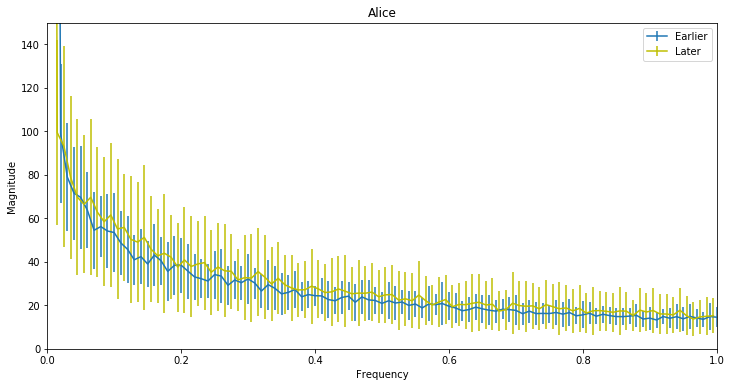

In [120]:
fig, ax = plt.subplots(figsize=(12, 6))
bin_x_2 = [b+0.005 for b in bin_x]
ax.errorbar(bin_x_2, sps_bin_1, sps_bin_std_1, label='Earlier') 
ax.errorbar(bin_x, sps_bin_2, sps_bin_std_2, c='y', label='Later') 
ax.set_xlim(0, max_freq); ax.set_ylim(0, ylim)
ax.set_xlabel('Frequency'); ax.set_ylabel('Magnitude')
ax.legend(); ax.set_title('Alice')

In [113]:
# Sam
vd_name_list = sorted(all_vd_loss.keys())[20:]
sps_bin_list = []
for i, vd_name in enumerate(vd_name_list):
    loss = all_vd_loss[vd_name]
    bin_x, sps_bin = FFT_average(loss, fps, max_freq, bin_len)
    sps_bin_list.append(sps_bin)
num_vd = len(sps_bin_list)
print(num_vd)

29


Text(0.5,1,'Sam')

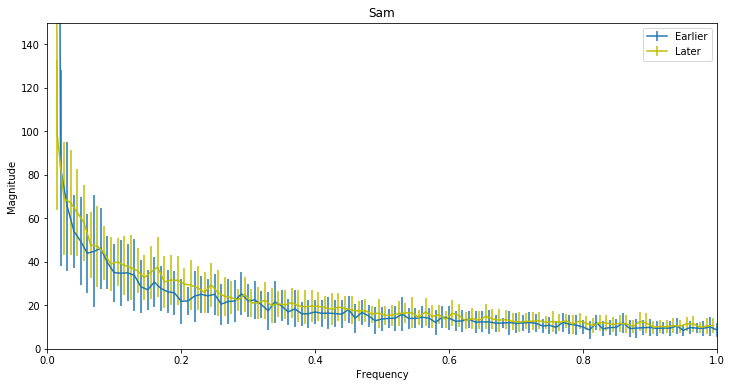

In [117]:
sps_bin_1 = np.mean(np.stack(sps_bin_list[:num_vd//2]), axis=0).tolist()
sps_bin_std_1 = np.std(np.stack(sps_bin_list[:num_vd//2]), axis=0)
sps_bin_2 = np.mean(np.stack(sps_bin_list[num_vd//2:]), axis=0).tolist()
sps_bin_std_2 = np.std(np.stack(sps_bin_list[num_vd//2:]), axis=0)
fig, ax = plt.subplots(figsize=(12, 6))
bin_x_2 = [b+0.005 for b in bin_x]
ax.errorbar(bin_x_2, sps_bin_1, sps_bin_std_1, label='Earlier') 
ax.errorbar(bin_x, sps_bin_2, sps_bin_std_2, c='y', label='Later') 
ax.set_xlim(0, max_freq); ax.set_ylim(0, ylim)
ax.set_xlabel('Frequency'); ax.set_ylabel('Magnitude')
ax.legend(); ax.set_title('Sam')